In [9]:
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import recall_score, precision_score

from evaluation.serialization import Serializer
from constants import TYPES, annotation_mapping, reverse_annotation_mapping, amino_acid_mapping
from utils.encoding import sequenceToCategorical, categoricalToOneHot, categoricalToSequence, oneHotToCategorical
from utils.Dataset import Dataset
from utils.helpers import getDatasetPath

In [19]:
run_timestamp = "20211113-1438"
base_path = f"../../results/{run_timestamp}/"
final_model = keras.models.load_model(base_path + f"models/final_model.h5")


test_data = Dataset(getDatasetPath()).getFolds([0])


test_x = np.array([categoricalToOneHot(sequenceToCategorical(seq, amino_acid_mapping), amino_acid_mapping) for seq in test_data["sequence"]])
predictions = final_model.predict(test_x)

test_data["prediction"] = np.array([categoricalToSequence(oneHotToCategorical(pred), reverse_annotation_mapping) for pred in predictions])

In [21]:
def getRelevantData(query: str) -> Tuple[np.ndarray, np.ndarray]:
    relevant_data = test_data.query(query)
    y_pred = np.array([sequenceToCategorical(seq, annotation_mapping) for seq in relevant_data["prediction"]])
    y_true = np.array([sequenceToCategorical(seq, annotation_mapping) for seq in relevant_data["annotation"]])

    return (y_pred, y_true)

In [29]:
y_pred, y_true = getRelevantData("kingdom == 'EUKARYA'")
precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=['S'])

C:\Users\juliu\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [41]:
y_pred, y_true = getRelevantData("kingdom == 'EUKARYA'")
labels = "STLIMO"
by_label_performance = {
    label: {
        "precision": precision_score(y_true.flatten(), y_pred.flatten(), labels=[labels.index(label)], average=None)[0],
        "recall": recall_score(y_true.flatten(), y_pred.flatten(), labels=[labels.index(label)], average=None)[0]
    } for label in labels
}

by_label_performance
performance = pd.DataFrame(
    (label, by_label_performance[label]["precision"], by_label_performance[label]["recall"])
    for label in labels
)
performance.columns = ["class", "precision", "recall"]
performance

C:\Users\juliu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\juliu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,precision,recall
0,S,0.914744,0.882109
1,T,0.000000,0.000000
2,L,0.000000,0.000000
3,I,0.986039,0.986447
4,M,0.791710,0.793354
5,O,0.915153,0.909094


In [3]:
cv_training_metrics = Serializer.load("cv_training_metrics")
cv_final_metrics = Serializer.load("cv_metrics")
final_training_metrics = Serializer.load("final_training_metrics")
final_metrics = Serializer.load("final_metrics")

In [9]:
cv_average_data = cv_final_metrics \
    .query("type == 'overall' and kingdom == 'overall' and metric != 'accuracy'") \
    .groupby(["metric", "type", "kingdom"]) \
    .agg(["mean", "std"]) \
    .sort_values(by="metric") \
    ["value"]

In [43]:
final_metrics.query("kingdom == 'EUKARYA'")

,metric,type,kingdom,value
0,mcc,TAT,EUKARYA,0.000000
5,mcc,SP,EUKARYA,0.867161
10,mcc,LIPO,EUKARYA,0.000000
15,mcc,NO_SP,EUKARYA,0.698590
20,mcc,overall,EUKARYA,0.901245
25,recall,TAT,EUKARYA,NaN
30,recall,SP,EUKARYA,0.451760
35,recall,LIPO,EUKARYA,NaN
40,recall,NO_SP,EUKARYA,0.392304
45,recall,overall,EUKARYA,0.595167


In [11]:
import matplotlib
matplotlib.rcParams.update({"errorbar.capsize": 8})

from colors import final_color, baseline_color, cv_color

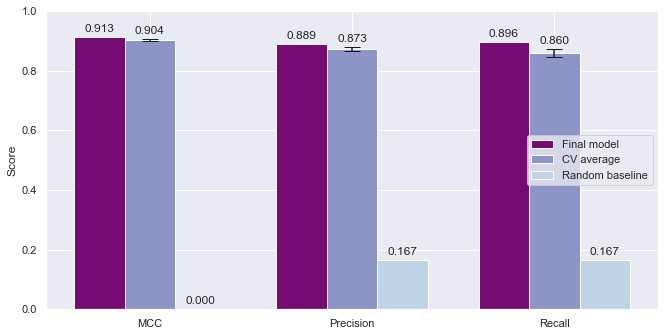

In [12]:
fig, ax = plt.subplots()
labels = ["MCC", "Precision", "Recall"]
width = 0.25
r1 = np.arange(len(labels))
r2 = r1 + width
r3 = r2 + width

final_model_values = ax.bar(
    r1,
    final_metrics.query("type == 'overall' and kingdom == 'overall' and metric != 'accuracy'").sort_values(by="metric")["value"],
    width,
    color=final_color,
    label="Final model"
)

cv_values = ax.bar(
    r2,
    cv_average_data["mean"],
    width,
    yerr = cv_average_data["std"],
    color=cv_color,
    label="CV average"
)

baseline_values = ax.bar(
    r3,
    random_baseline_values,
    width,
    color=baseline_color,
    label="Random baseline"
)

ax.set_ylabel("Score")
ax.set_xticks(r2)
ax.set_xticklabels(labels)
ax.legend(loc="center right")

ax.set_ylim([0.0, 1])

ax.bar_label(final_model_values, padding=3, fmt="%.3f")
ax.bar_label(cv_values, padding=3, fmt="%.3f")
ax.bar_label(baseline_values, padding=3, fmt="%.3f")

fig.tight_layout()

fig.set_size_inches(10, 5)
fig.savefig("output/overall_performance.png", dpi=240)